# Assignment8

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as LM
from feature_engine.encoding import CountFrequencyEncoder as CFE
from sklearn.model_selection import train_test_split as TTS
import statsmodels.api as sm
import numpy as np

# How Much is Your Car Worth?

Data about the retail price of 2005 General Motors cars can be found in `car_data.csv`.

The columns are:

1. Price: suggested retail price of the used 2005 GM car in excellent condition.
2. Mileage: number of miles the car has been driven
3. Make: manufacturer of the car such as Saturn, Pontiac, and Chevrolet
4. Model: specific models for each car manufacturer such as Ion, Vibe, Cavalier
5. Trim (of car): specific type of car model such as SE Sedan 4D, Quad Coupe 2D          
6. Type: body type such as sedan, coupe, etc.      
7. Cylinder: number of cylinders in the engine        
8. Liter: a more specific measure of engine size     
9. Doors: number of doors           
10. Cruise: indicator variable representing whether the car has cruise control (1 = cruise)
11. Sound: indicator variable representing whether the car has upgraded speakers (1 = upgraded)
12. Leather: indicator variable representing whether the car has leather seats (1 = leather)

## Tasks, Part 1

1. Find the linear regression equation for mileage vs price.
2. Chart the original data and the equation on the chart.
3. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)

## Tasks, Part 2

1. Use mileage, cylinders, liters, doors, cruise, sound, and leather to find the linear regression equation.
2. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)
3. Find the combination of the factors that is the best predictor for price.

## Tasks, Hard Mode

1. Research dummy variables in scikit-learn to see how to use the make, model, and body type.
2. Find the best combination of factors to predict price.

In [176]:
df = pd.read_csv("car_data.csv")
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [180]:
model = OLS(df["Price"],add_constant(df["Mileage"])).fit()
model.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.75
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           4.68e-05
Time:                        09:39:55   Log-Likelihood:                -8527.8
No. Observations:                 804   AIC:                         1.706e+04
Df Residuals:                     802   BIC:                         1.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.476e+04    904.363     27.383      0.000     2.3e+04    2.65e+04
Mileage       -0.1725      0.042     -4.093      0.000      -0.255      -0.090
==============================================================================
Omnibus:                      236.450   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.297
Skew:                           1.522   Prob(JB):                    3.64e-132
Kurtosis:                       5.966   Cond. No.                     5.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R squared score is low.

Text(0, 0.5, 'price')

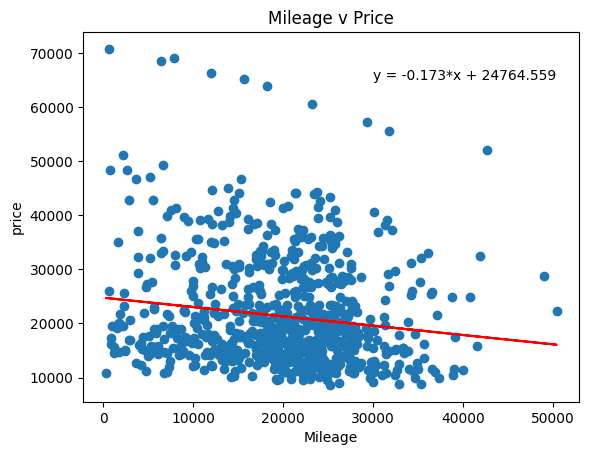

In [208]:
slope,intercept = np.polyfit(df["Mileage"],df["Price"],1)
line = df["Mileage"]*slope + intercept
plt.scatter(df["Mileage"],df["Price"])
plt.plot(df["Mileage"],line,color="red")
plt.text(30000,65000,f"y = {slope:.3f}*x + {intercept:.3f}")
plt.title("Mileage v Price")
plt.xlabel("Mileage")
plt.ylabel("price")

In [219]:

def Log(name,Predictors,ResponseV,SignificantFeatures,excludeCols,skimmed,pValues,rSq,rAdjSq):
    with open(str(name),"a") as f:
        f.write(f"""
            X:{Predictors}
            Y:{ResponseV}
            Significant Features: {SignificantFeatures}
            Removed Column: {excludeCols}
            Skimmed:{skimmed}
            pValues:{pValues}
            R^2:{rSq}
            Adj R^2:{rAdjSq}
        """)


def getPValues(x,y,pValueObj = True):
    X = sm.add_constant(x)
    lr = sm.OLS(y,X).fit()
    summary_table = np.array(lr.summary().tables[1].data)
    rSquared, rAdjSquared = [float(i[-1]) for i in lr.summary().tables[0].data[:2]]
    _,secIdx = [j for i in np.where(summary_table[:1] == "P>|t|") for j in i]
    pValue = summary_table[2:,0:secIdx+1:secIdx]
    if pValueObj == False:
        return {i[0]:i[1] for i in pValue}
    return {
        "features": [i[0] for i in pValue[0:,:1]],
        "pValues": [float(i[0]) for i in pValue[0:,1:]],
        "R^2": rSquared,
        "R^2-adj":rAdjSquared 
    }

def stepWiseRegCombined(X,y,SignificanceLevel = 0.05,thresholdToStop = 2, log = False,ResponseVNameForLog = "Not Provided",withModel = False,ReadLog = True):
    name = ""

    if log == True:
        import time as t
        name = f"Forward And Backward Regression log {t.strftime('%y_%m_%d %H_%M_%S')}.txt"

    featuresName = list(X.columns)
    SignificantFeatures = []
    excludeCols = []
    Con=True
    skimmed = {i:0 for i in featuresName}
    if featuresName.__len__() == 1:
        return {
            "model": sm.OLS(y,X).fit(),
            "oneFeatureModel": featuresName
        }
    excludeCols = featuresName[:2]
    featurePValueObj = getPValues(X[excludeCols],y)
    significantPVal = [i for i in featurePValueObj["pValues"] if i < SignificanceLevel]
    if significantPVal.__len__() != 0:
        zeroIndex = featurePValueObj["pValues"].index(0)
        significantFeature = featurePValueObj["features"][zeroIndex]
        SignificantFeatures = [*SignificantFeatures,significantFeature]
        featuresName.pop(featuresName.index(significantFeature))
        excludeColIdx = 0
        if zeroIndex == 0:
            excludeColIdx = 1
        excludeCols = [featurePValueObj["features"][excludeColIdx]]
        featuresName.pop(featuresName.index(featurePValueObj["features"][excludeColIdx]))
        featuresName = [*featuresName,featurePValueObj["features"][excludeColIdx]]
        skimmed = {
            **skimmed,
            featurePValueObj["features"][excludeColIdx]:1,
        }
        del skimmed[significantFeature]
    else:
        featureLowest = featurePValueObj["features"][featurePValueObj["pValues"].index(min(featurePValueObj["pValues"]))]
        featuresName.pop(featuresName.index(featureLowest))
        featuresName = [*featuresName,featureLowest]
        excludeCols = [featureLowest]
        skimmed = {
            **skimmed,
            featurePValueObj["features"][0]:1,
            featurePValueObj["features"][1]:1
        }
    
    if log == True:
        Log(Predictors=[X.columns[:2]],ResponseV=ResponseVNameForLog,SignificantFeatures=SignificantFeatures,excludeCols=excludeCols,name=name,skimmed=skimmed,pValues=featurePValueObj["pValues"],rAdjSq=featurePValueObj["R^2-adj"],rSq=featurePValueObj["R^2"])

    while Con == True:
        colsToRemove = []
        cols = [] 
        for i in featuresName:
            if i not in excludeCols:
                cols.append(i)
            else:
                colsToRemove.append(i)
        newX = X.drop(columns=colsToRemove)
        if cols.__len__() == 0:
            break
        featurePValueObj = getPValues(newX[[*SignificantFeatures,cols[0]]],y)
        if log == True:
            Log(Predictors=[*SignificantFeatures,cols[0]],ResponseV=ResponseVNameForLog,SignificantFeatures=SignificantFeatures,excludeCols=excludeCols,name=name,skimmed=skimmed,pValues=featurePValueObj["pValues"],rAdjSq=featurePValueObj["R^2-adj"],rSq=featurePValueObj["R^2"])
            
        excludeCols = []
        significantPVal = [i for i in featurePValueObj["pValues"] if i < SignificanceLevel]
        if significantPVal.__len__() != 0:
            notAll0s = []
            all0IdxFeatures = []
            for ind,i in enumerate(featurePValueObj["pValues"]):
                if i < SignificanceLevel:
                    all0IdxFeatures.append(featurePValueObj["features"][ind])
                else:
                    notAll0s.append(featurePValueObj["features"][ind])
            NotAdyInSigFeatures = [i for i in all0IdxFeatures if i not in SignificantFeatures]
            SignificantFeatures = [i for i in [*SignificantFeatures,*NotAdyInSigFeatures] if i not in notAll0s]
            for i in NotAdyInSigFeatures:
                featuresName.pop(featuresName.index(i))
                del skimmed[i]
            for i in notAll0s:
                if i in featuresName: 
                    featuresName.pop(featuresName.index(i))
                    skimmed = {
                        **skimmed,
                        i:skimmed[i] + 1,
                    }
                else:
                    skimmed = {
                        **skimmed,
                        i:1,
                    }
    
                featuresName = [*featuresName,i]
                excludeCols = [i]

        else:
            featureLowest = featurePValueObj["features"][featurePValueObj["pValues"].index(min(featurePValueObj["pValues"]))]
            featuresName.pop(featuresName.index(featureLowest))
            featuresName = [*featuresName,featureLowest]
            excludeCols = [featureLowest]
        
        if SignificantFeatures.__len__() == 0:
            for i in skimmed:
                if skimmed[i] == thresholdToStop + 2:
                    Con = True
        else:
            innerCon = False
            for i in skimmed.values():
                if i < thresholdToStop:
                    innerCon = True
            Con = innerCon
    
    if ReadLog == True and log == True:
        with open(name,"r") as f:
            print(f.read())
    
    if withModel == True:
        return {
            "SignificantFeatures":SignificantFeatures,
            "modelWithSF":sm.OLS(y,sm.add_constant(X[SignificantFeatures])).fit()
        }
    else:
        return SignificantFeatures




In [228]:
X = df[["Mileage","Doors", "Cruise", "Sound", "Leather","Cylinder", "Liter"]]
y = df["Price"]

model2 = stepWiseRegCombined(X,y,log=True,ResponseVNameForLog="Price",withModel=True,ReadLog=True,SignificanceLevel=0.01)
model2


            X:[Index(['Mileage', 'Doors'], dtype='object')]
            Y:Price
            Significant Features: ['Mileage']
            Removed Column: ['Doors']
            Skimmed:{'Doors': 1, 'Cruise': 0, 'Sound': 0, 'Leather': 0, 'Cylinder': 0, 'Liter': 0}
            pValues:[0.0, 0.0]
            R^2:0.04
            Adj R^2:0.038
        
            X:['Mileage', 'Cruise']
            Y:Price
            Significant Features: ['Mileage']
            Removed Column: ['Doors']
            Skimmed:{'Doors': 1, 'Cruise': 0, 'Sound': 0, 'Leather': 0, 'Cylinder': 0, 'Liter': 0}
            pValues:[0.0, 0.0]
            R^2:0.209
            Adj R^2:0.207
        
            X:['Mileage', 'Cruise', 'Sound']
            Y:Price
            Significant Features: ['Mileage', 'Cruise']
            Removed Column: []
            Skimmed:{'Doors': 1, 'Sound': 0, 'Leather': 0, 'Cylinder': 0, 'Liter': 0}
            pValues:[0.0, 0.0, 0.005]
            R^2:0.217
            Adj R^2:0.21

{'SignificantFeatures': ['Mileage',
  'Cruise',
  'Sound',
  'Leather',
  'Cylinder',
  'Doors'],
 'modelWithSF': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d8d3dcf6d0>}

- Each added a significance to the model, one thing to note here r^2 is 0.441. 
- The highest it reached when it is .442. Liter is highly co-related with Mileage. So model removes it as it is redundant. 
- Cylinder very well explains the variation in the price. 
- May be categorical predictor may be more info in predicted price

The best features are ``['Mileage',
  'Cruise',
  'Sound',
  'Leather',
  'Cylinder',
  'Doors']`` In design Matrix based on question 2

In [177]:
df.isnull().sum()

Price       0
Mileage     0
Make        0
Model       0
Trim        0
Type        0
Cylinder    0
Liter       0
Doors       0
Cruise      0
Sound       0
Leather     0
dtype: int64

In [178]:
df = pd.get_dummies(data=df,columns=["Type","Make"])
df.head()

,Price,Mileage,Model,Trim,Cylinder,Liter,Doors,Cruise,Sound,Leather,...,Type_Coupe,Type_Hatchback,Type_Sedan,Type_Wagon,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
0,17314.103129,8221,Century,Sedan 4D,6,3.1,4,1,1,1,...,0,0,1,0,1,0,0,0,0,0
1,17542.036083,9135,Century,Sedan 4D,6,3.1,4,1,1,0,...,0,0,1,0,1,0,0,0,0,0
2,16218.847862,13196,Century,Sedan 4D,6,3.1,4,1,1,0,...,0,0,1,0,1,0,0,0,0,0
3,16336.913140,16342,Century,Sedan 4D,6,3.1,4,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,16339.170324,19832,Century,Sedan 4D,6,3.1,4,1,0,1,...,0,0,1,0,1,0,0,0,0,0


In [179]:
con = df.corr()

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather,Type_Convertible,Type_Coupe,Type_Hatchback,Type_Sedan,Type_Wagon,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
Price,1.000000,-0.143051,0.569086,0.558146,-0.138750,0.430851,-0.124348,0.157197,0.508018,-0.168087,-0.206178,-0.034802,0.045134,-0.017768,0.659297,-0.404598,-0.142095,0.335404,-0.211701
Mileage,-0.143051,1.000000,-0.029461,-0.018641,-0.016944,0.025037,-0.026146,0.001005,0.027436,0.001510,-0.025691,-0.015905,0.027016,0.024193,-0.037472,-0.017505,-0.029892,0.056182,0.017467
Cylinder,0.569086,-0.029461,1.000000,0.957897,0.002206,0.354285,-0.089704,0.075520,0.061533,-0.041657,-0.055019,0.180832,-0.269058,0.175317,0.534896,-0.157535,0.114436,-0.371877,-0.191548
Liter,0.558146,-0.018641,0.957897,1.000000,-0.079259,0.377509,-0.065527,0.087332,0.065886,0.046832,-0.125252,0.140098,-0.255308,0.188093,0.406216,-0.124052,0.113863,-0.326754,-0.180941
Doors,-0.138750,-0.016944,0.002206,-0.079259,1.000000,-0.047674,-0.062530,-0.061969,-0.462921,-0.825444,0.157973,0.694906,0.163594,0.184913,0.087104,-0.145813,0.040943,-0.025680,-0.064852
Cruise,0.430851,0.025037,0.354285,0.377509,-0.047674,1.000000,-0.091730,-0.070573,0.147689,-0.040646,-0.264846,0.125714,-0.044285,0.190645,0.190645,-0.293190,0.000939,0.233118,-0.199044
Sound,-0.124348,-0.026146,-0.089704,-0.065527,-0.062530,-0.091730,1.000000,0.165444,-0.043637,0.097838,0.073544,-0.015079,-0.142362,-0.011824,-0.091932,0.259566,-0.074314,-0.087209,-0.139371
Leather,0.157197,0.001005,0.075520,0.087332,-0.061969,-0.070573,0.165444,1.000000,0.009285,0.063507,0.090697,-0.100940,-0.003375,-0.212930,0.205301,0.155492,-0.089854,0.003809,-0.152794
Type_Convertible,0.508018,0.027436,0.061533,0.065886,-0.462921,0.147689,-0.043637,0.009285,1.000000,-0.118244,-0.073129,-0.321686,-0.075731,-0.085600,0.086456,-0.104170,-0.123326,0.338253,-0.073129
Type_Coupe,-0.168087,0.001510,-0.041657,0.046832,-0.825444,-0.040646,0.097838,0.063507,-0.118244,1.000000,-0.130397,-0.573605,-0.135037,-0.152636,-0.152636,0.229685,0.032672,-0.186641,0.119221


Since Cylinder and Liter are highly co-related removing Liter. 

In [87]:
newX = df[["Trim","Doors"]]
y = df["Price"]


In [88]:
xt,xT,yt,yT = TTS(newX,y,test_size=0.3,random_state=100)

In [115]:
noveltyLabels = [i for i in xT["Trim"].unique() if i not in xt["Trim"].unique()]
len(noveltyLabels)

0

In [114]:
overFitLabels = [i for i in xt["Trim"].unique() if i not in xT["Trim"].unique()]
len(overFitLabels)

0

In [125]:
Cc = CFE(encoding_method="count")
TrimNew = Cc.fit_transform(df[["Trim"]])

OLS(y,add_constant(TrimNew)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01290
Date:                Mon, 20 Feb 2023   Prob (F-statistic):              0.910
Time:                        07:51:34   Log-Likelihood:                -8536.1
No. Observations:                 804   AIC:                         1.708e+04
Df Residuals:                     802   BIC:                         1.709e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.138e+04    452.000     47.292      0.000    2.05e+04    2.23e+04
Trim          -0.6325      5.569     -0.114      0.910     -11.565      10.300
==============================================================================
Omnibus:                      249.798   Durbin-Watson:                   0.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.354
Skew:                           1.574   Prob(JB):                    3.36e-150
Kurtosis:                       6.261   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
CF = CFE(encoding_method="frequency")
TrimNew2 = CF.fit_transform(df[["Trim"]])

OLS(y,add_constant(TrimNew2)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01290
Date:                Mon, 20 Feb 2023   Prob (F-statistic):              0.910
Time:                        07:56:32   Log-Likelihood:                -8536.1
No. Observations:                 804   AIC:                         1.708e+04
Df Residuals:                     802   BIC:                         1.709e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.138e+04    452.000     47.292      0.000    2.05e+04    2.23e+04
Trim        -508.5541   4477.738     -0.114      0.910   -9298.025    8280.917
==============================================================================
Omnibus:                      249.798   Durbin-Watson:                   0.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.354
Skew:                           1.574   Prob(JB):                    3.36e-150
Kurtosis:                       6.261   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
dum = pd.get_dummies(data=df["Trim"],columns=["Trim"])
OLS(y,add_constant(dum)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     28.41
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          5.33e-134
Time:                        08:22:28   Log-Likelihood:                -8132.9
No. Observations:                 804   AIC:                         1.636e+04
Df Residuals:                     757   BIC:                         1.658e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.176e+04    257.992     84.361      0.000    2.13e+04    2.23e+04
AWD Sportwagon 4D   -5863.1792   1926.066     -3.044      0.002   -9644.245   -2082.114
Aero Conv 2D         9999.1914   1926.066      5.192      0.000    6218.126    1.38e+04
Aero Sedan 4D        4947.9961   1374.098      3.601      0.000    2250.501    7645.491
Aero Wagon 4D        7013.3069   1926.066      3.641      0.000    3232.242    1.08e+04
Arc Conv 2D          1.339e+04   1926.066      6.950      0.000    9604.815    1.72e+04
Arc Sedan 4D         7810.8252   1374.098      5.684      0.000    5113.330    1.05e+04
Arc Wagon 4D         8359.4432   1926.066      4.340      0.000    4578.378    1.21e+04
CX Sedan 4D         -2278.9790   1926.066     -1.183      0.237   -6060.044    1502.086
CXL Sedan 4D         -174.0005   1926.066     -0.090      0.928   -3955.066    3607.065
CXS Sedan 4D          393.3623   1926.066      0.204      0.838   -3387.703    4174.428
Conv 2D              1.974e+04   1926.066     10.247      0.000     1.6e+04    2.35e+04
Coupe 2D            -1105.2414    891.737     -1.239      0.216   -2855.812     645.329
Custom Sedan 4D     -3281.6293   1926.066     -1.704      0.089   -7062.695     499.436
DHS Sedan 4D          1.57e+04   1926.066      8.150      0.000    1.19e+04    1.95e+04
DTS Sedan 4D         1.616e+04   1926.066      8.391      0.000    1.24e+04    1.99e+04
GT Coupe 2D         -5526.3059   1926.066     -2.869      0.004   -9307.371   -1745.241
GT Sedan 4D         -3166.6724   1374.098     -2.305      0.021   -5864.168    -469.177
GT Sportwagon       -6046.5800   1926.066     -3.139      0.002   -9827.645   -2265.515
GTP Sedan 4D        -1438.0725   1926.066     -0.747      0.456   -5219.138    2342.993
GXP Sedan 4D          813.4063   1926.066      0.422      0.673   -2967.659    4594.472
Hardtop Conv 2D      4.117e+04   1926.066     21.377      0.000    3.74e+04     4.5e+04
L300 Sedan 4D       -5213.4730   1926.066     -2.707      0.007   -8994.538   -1432.408
LS Coupe 2D         -7044.6231   1131.791     -6.224      0.000   -9266.444   -4822.802
LS Hatchback 4D     -1.065e+04   1926.066     -5.528      0.000   -1.44e+04   -6866.385
LS MAXX Hback 4D    -4614.6978   1926.066     -2.396      0.017   -8395.763    -833.632
LS Sedan 4D         -6886.0920    891.737     -7.722      0.000   -8636.662   -5135.522
LS Sport Coupe 2D   -8219.9564   1926.066     -4.268      0.000    -1.2e+04   -4438.891
LS Sport Sedan 4D   -7992.7282   1926.066     -4.150      0.000   -1.18e+04   -4211.663
LT Coupe 2D         -1202.1697   1926.066     -0.624      0.533   -4983.235    2578.896
LT Hatchback 4D     -1.059e+04   1926.066     -5.500      0.000   -1.44e+04   -6812.435
LT MAXX Hback 4D    -3944.9012   1926.066     -2.048      0.041   -7725.967    -163.836
LT 

In [148]:
df[["Trim"]].value_counts()

Trim               
Sedan 4D               170
LS Sedan 4D             50
Coupe 2D                50
LS Coupe 2D             30
LT Sedan 4D             30
GT Sedan 4D             20
SE Sedan 4D             20
Quad Coupe 2D           20
Aero Sedan 4D           20
Arc Sedan 4D            20
Linear Wagon 4D         14
SS Sedan 4D             10
Linear Conv 2D          10
LT Coupe 2D             10
LT Hatchback 4D         10
LT MAXX Hback 4D        10
Special Ed Ultra 4D     10
Limited Sedan 4D        10
Linear Sedan 4D         10
SS Coupe 2D             10
MAXX Hback 4D           10
LS Sport Sedan 4D       10
SVM Sedan 4D            10
SVM Hatchback 4D        10
SLE Sedan 4D            10
AWD Sportwagon 4D       10
LS Hatchback 4D         10
LS Sport Coupe 2D       10
LS MAXX Hback 4D        10
Aero Wagon 4D           10
Arc Conv 2D             10
Arc Wagon 4D            10
CX Sedan 4D             10
CXL Sedan 4D            10
CXS Sedan 4D            10
Conv 2D                 10
Custom S

KeyError: 'False: boolean label can not be used without a boolean index'